In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from PIL import Image, ImageFilter
from matplotlib import cm
from scipy.fftpack import dct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import *
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from dataset_prep import MNISTDataset
import torchvision 

In [2]:
class MNIST(Dataset):

    def __init__(self, ref, transform=None, **kwargs):
        super(MNIST, self).__init__()
        self.__transform = transform

        mnist = ref

        if not ('train' in kwargs.keys()):
            kwargs['train'] = False
        if not ('test' in kwargs.keys()):
            kwargs['test'] = False

        self.__train = kwargs['train']
        self.__test = kwargs['test']

        self.__data = mnist.get_training_data() if (self.__train or not self.__test) else mnist.get_testing_data()

    def __len__(self):
        return len(self.__data)

    def __getitem__(self, item):

        data = self.__data[item]

        image, label = data
        if self.__transform:
            image = self.__transform(image)

        return image, torch.tensor(label)
    

class ToTensor:

    def __call__(self, sample):
        image = sample
        width, height = image.shape
        return torch.from_numpy(image).view(1, width, height)


In [3]:
'''
    Model 1 : FFNN 


'''


class FCNeuralNet(nn.Module):

    def __init__(self, input_size, n_classes=10, hidden_depth=1, hidden_count=15, ):
        super(FCNeuralNet, self).__init__()

        self.__stack = nn.Sequential(
            nn.Linear(input_size, hidden_count),
            nn.ReLU(),
            *([nn.Linear(hidden_count, hidden_count), nn.ReLU()] * hidden_depth),
            nn.Linear(hidden_count, n_classes)
        )

    def forward(self, x):
        x = self.__stack(x)
        return x

In [4]:
"""

    Model 2 : LetNet 

"""


# Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [5]:

"""

    Model 3 : LetNet with Attention 

"""


# Defining the convolutional neural network
class LeNet5_Attention(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5_Attention, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

        # Spatial Transformer

        # localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Forward function for Spatial Transformer
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners= True)

        return x
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Feed Forward
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [39]:
# Hyper-parameters

EPOCHS = 5
LR = 1e-3
NUM_CLASS = 10
BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"


In [35]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [36]:
def train_test(model, train_loader, test_loader, l):
    # Device

    loss = nn.CrossEntropyLoss()
    opt = op.Adam(model.parameters(), lr=LR)
    sched = ExponentialLR(opt, gamma= 0.9)

    # Training Loop

    st = time.time()

    for epoch in range(EPOCHS):

        for idx, (img, target) in enumerate(train_loader):
            opt.zero_grad()

            logits = model(img)
            L = loss(logits, target)

            L.backward()

            opt.step()   

        sched.step()
        
    et = time.time()

    print(f"Training Time ::--> {round(et - st, 5)} sec")

    st = time.time()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

        et = time.time()
        print(f"Testing Time ::--> {round(et - st, 5)} sec")
        print(f'Accuracy of the network on the {l} test images: {100 * correct / total} %')


def train_cnn(dataset="MNIST"):
    ref = MNISTDataset(dataset)

    train_dataset = MNIST(ref, Compose([ToTensor(), Resize([32, 32])]), train=True)
    test_dataset = MNIST(ref, Compose([ToTensor(), Resize([32, 32])]), test=True)

    model = LeNet5(NUM_CLASS)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    train_test(model, train_loader, test_loader, len(test_dataset))

def train_Attention(dataset="MNIST"):
    ref = MNISTDataset(dataset)

    train_dataset = MNIST(ref, Compose([ToTensor(), Resize([32, 32])]), train=True)
    test_dataset = MNIST(ref, Compose([ToTensor(), Resize([32, 32])]), test=True)

    model = LeNet5_Attention(NUM_CLASS)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    out_model = train_test(model, train_loader, test_loader, len(test_dataset))


In [8]:
print("LeNet5 ------ MNIST")
train_cnn("MNIST")

LeNet5 ------ MNIST


e:\Anaconda3\envs\Pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Time ::--> 10.24249 sec


KeyboardInterrupt: 

LeNet5_Attention ------ MNIST
Training Time ::--> 5.3632 sec
Testing Time ::--> 0.4471 sec
Accuracy of the network on the 2000 test images: 99.85 %


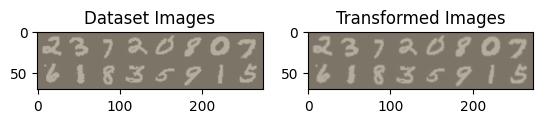

In [40]:
print("LeNet5_Attention ------ MNIST")
train_Attention("MNIST")

In [ ]:
print("LeNet5 ------ Speech")
train_cnn("S2S")

LeNet5 ------ Speech
Training Time ::--> 1.13625 sec
Testing Time ::--> 0.07302 sec
Accuracy of the network on the 300 test images: 99.0 %


LeNet5_Attention ------ Speech
Training Time ::--> 0.78017 sec
Testing Time ::--> 0.09202 sec
Accuracy of the network on the 300 test images: 91.0 %


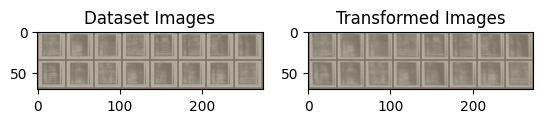

In [41]:
print("LeNet5_Attention ------ Speech")
train_Attention("S2S")